# Import bibliotek

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import pandas_profiling

# Odpowiednie przygotowanie danych 

Wczytanie danych

In [77]:
dane_proba = pd.read_csv('../dane/Weather.csv', sep=',')
dane_proba.head()

,Unnamed: 0,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,...,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,1,Auckland,2016-01-01,2016,1,1,68,65,62,64,...,30.09,30.01,6,6,4,21,15,28.0,0,Rain
1,2,Auckland,2016-01-02,2016,1,2,68,66,64,64,...,29.90,29.80,6,5,1,33,21,46.0,0,Rain
2,3,Auckland,2016-01-03,2016,1,3,77,72,66,70,...,29.73,29.68,6,6,1,18,12,NaN,0,Rain
3,4,Auckland,2016-01-04,2016,1,4,73,66,60,66,...,29.90,29.77,6,6,6,15,10,NaN,0,Rain
4,5,Auckland,2016-01-05,2016,1,5,69,62,55,55,...,30.14,30.09,6,6,6,13,7,NaN,0,NaN


Usunięcie kolumny

In [78]:
dane = pd.read_csv('../dane/Weather.csv', sep=',', usecols = list(range(1,dane_proba.shape[1])))
dane.head()

,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,...,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,low_wind,precip,events
0,Auckland,2016-01-01,2016,1,1,68,65,62,64,60,...,30.09,30.01,6,6,4,21,15,28.0,0,Rain
1,Auckland,2016-01-02,2016,1,2,68,66,64,64,63,...,29.90,29.80,6,5,1,33,21,46.0,0,Rain
2,Auckland,2016-01-03,2016,1,3,77,72,66,70,67,...,29.73,29.68,6,6,1,18,12,NaN,0,Rain
3,Auckland,2016-01-04,2016,1,4,73,66,60,66,60,...,29.90,29.77,6,6,6,15,10,NaN,0,Rain
4,Auckland,2016-01-05,2016,1,5,69,62,55,55,52,...,30.14,30.09,6,6,6,13,7,NaN,0,NaN


Wyświetlenie etykiet kolumn

In [79]:
dane.columns

Index(['city', 'date', 'year', 'month', 'day', 'high_temp', 'avg_temp',
       'low_temp', 'high_dewpt', 'avg_dewpt', 'low_dewpt', 'high_humidity',
       'avg_humidity', 'low_humidity', 'high_hg', 'avg_hg', 'low_hg',
       'high_vis', 'avg_vis', 'low_vis', 'high_wind', 'avg_wind', 'low_wind',
       'precip', 'events'],
      dtype='object')

Wyświetlenie typów danych

In [80]:
dane.dtypes

city              object
date              object
year               int64
month              int64
day                int64
high_temp          int64
avg_temp           int64
low_temp           int64
high_dewpt         int64
avg_dewpt          int64
low_dewpt          int64
high_humidity      int64
avg_humidity       int64
low_humidity       int64
high_hg          float64
avg_hg           float64
low_hg           float64
high_vis           int64
avg_vis            int64
low_vis            int64
high_wind          int64
avg_wind           int64
low_wind         float64
precip            object
events            object
dtype: object

Zliczenie wartości NaN w danych

In [81]:
dane.isna().sum()

city                0
date                0
year                0
month               0
day                 0
high_temp           0
avg_temp            0
low_temp            0
high_dewpt          0
avg_dewpt           0
low_dewpt           0
high_humidity       0
avg_humidity        0
low_humidity        0
high_hg             0
avg_hg              0
low_hg              0
high_vis            0
avg_vis             0
low_vis             0
high_wind           0
avg_wind            0
low_wind         1326
precip              0
events           2217
dtype: int64

Wyświetlenie wymiaru danych

In [82]:
dane.shape

(3655, 25)

Zamiana NaN na 'No event'

In [83]:
dane['events'] = dane['events'].fillna('No event')

Zamiana 'T' na 0.001

In [84]:
dane['precip'] = dane['precip'].replace('T', 0.001)

Zamiana NaN na 0

In [85]:
dane['low_wind'] = dane['low_wind'].fillna(0)

Zmiana nazwy low_wind na max_wind_gust

In [86]:
dane.rename(columns={'low_wind': 'max_wind_gust'}, inplace = True)

In [87]:
#przeliczenie temp na st C
#wykres, wnioski

Wyświetlenie unikalnych wartości w kolumnie events

In [88]:
dane['events'].unique()

array(['Rain', 'No event', 'Fog , Rain , Thunderstorm', 'Fog , Rain',
       'Rain , Thunderstorm', 'Rain , Hail', 'Fog', 'Thunderstorm',
       'Rain , Hail , Thunderstorm', 'Snow', 'Rain , Snow',
       'Fog , Thunderstorm', 'Fog , Snow', 'Fog , Rain , Snow',
       'Fog , Snow , Thunderstorm'], dtype=object)

Utworzenie nowych kolumn

In [89]:
def create(x):
    dane[x] = dane['events']
    dane[x] = [i.find(x) for i in dane[x]]
    dane[x] = dane[x].map({-1: 0}).fillna(1)
    
create("Rain")
create("Fog")
create("Thunderstorm")
create("Snow")
create("Hail")

Zmiana jednostek temperatury

In [90]:
def convert_to_C(x):
    dane[x] = ((dane[x]-32)*5/9).round(2)
    
for i in ['avg_temp', 'low_temp', 'high_temp', 'avg_dewpt', 'low_dewpt', 'high_dewpt']:
    convert_to_C(i)


Zmiana jednostek odległości

In [91]:
def convert_to_cm(x):
    dane[x] = (dane[x]*2.54).round(2)
    
for i in ['avg_hg', 'low_hg', 'high_hg']:
    convert_to_cm(i)
    
def convert_to_m(x):
    dane[x] = (dane[x]*1609.344).round(2)
    
for i in ['avg_vis', 'low_vis', 'high_vis']:
    convert_to_m(i)

Zmiana jednostek prędkości wiatru

In [92]:
def convert_to_kph(x):
    dane[x] = (dane[x]*1.609344).round(2)
    
for i in ['avg_wind', 'max_wind_gust', 'high_wind']:
    convert_to_kph(i)
    

Zmiana typu danych kolumny z ilością opadów

In [93]:
dane['precip'] = pd.to_numeric(dane['precip'])
dane['precip'].describe()

count    3655.000000
mean        0.080909
std         0.436573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.680000
Name: precip, dtype: float64

Zmiana jednostek ilości opadów

In [94]:
def convert_to_mm(x):
    dane[x] = (dane[x]*2.54*10).round(2)

convert_to_mm('precip')

Zwrócenie 5 pierwszych wierszy

In [95]:
dane.head()

,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,...,high_wind,avg_wind,max_wind_gust,precip,events,Rain,Fog,Thunderstorm,Snow,Hail
0,Auckland,2016-01-01,2016,1,1,20.00,18.33,16.67,17.78,15.56,...,33.80,24.14,45.06,0.0,Rain,1.0,0.0,0.0,0.0,0.0
1,Auckland,2016-01-02,2016,1,2,20.00,18.89,17.78,17.78,17.22,...,53.11,33.80,74.03,0.0,Rain,1.0,0.0,0.0,0.0,0.0
2,Auckland,2016-01-03,2016,1,3,25.00,22.22,18.89,21.11,19.44,...,28.97,19.31,0.00,0.0,Rain,1.0,0.0,0.0,0.0,0.0
3,Auckland,2016-01-04,2016,1,4,22.78,18.89,15.56,18.89,15.56,...,24.14,16.09,0.00,0.0,Rain,1.0,0.0,0.0,0.0,0.0
4,Auckland,2016-01-05,2016,1,5,20.56,16.67,12.78,12.78,11.11,...,20.92,11.27,0.00,0.0,No event,0.0,0.0,0.0,0.0,0.0


In [160]:
dane.city.value_counts()

Chicago      731
San Diego    731
Mumbai       731
Auckland     731
Beijing      731
Name: city, dtype: int64

# Redukcja wymiaru

Standaryzacja

In [96]:
x = dane.iloc[:, 5:24].values
x = StandardScaler().fit_transform(x)

In [97]:
pca = PCA()
principalComponents = pca.fit_transform(x)

In [98]:
pca.explained_variance_ratio_.cumsum() #4 na poziomie odcięcia 0.8

array([0.44234403, 0.58855495, 0.72693423, 0.80744791, 0.85705077,
       0.90429329, 0.93899741, 0.96087866, 0.97609654, 0.9879299 ,
       0.9916159 , 0.99439732, 0.99605243, 0.99749287, 0.99871944,
       0.99961685, 0.99982656, 0.99998368, 1.        ])

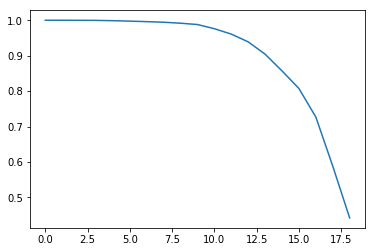

In [99]:
data = pca.explained_variance_ratio_.cumsum()[::-1] 
sns.lineplot(y =data, x = list(range(len(data)))) #optymalnie 10

In [100]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, dane[['events']]], axis = 1)

Skumulowana wariancja tłumaczona przez komponenty

In [101]:
pca.explained_variance_ratio_.cumsum()

array([0.44234403, 0.58855495])

Wykres rozrzutu

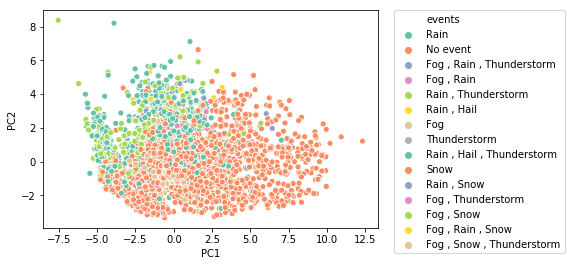

In [157]:
#import plotly.plotly as py
fig = sns.scatterplot(data = finalDf, x = 'PC1', y = 'PC2', hue = dane['events'], palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0,)

#plot_url = py.plot(fig)
#ggplot(aes('PC1','PC2', color = 'events'), finalDf) + geom_point()

In [23]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(df1['PC1'], df1['PC2'], df1['PC3'], s=60, label=dane[['events']], alpha=0.70, c= dane['events'], cmap=cm.brg)
#ax.view_init(30, 185)
#plt.show()

In [24]:
#https://towardsdatascience.com/customizing-plots-with-python-matplotlib-bcf02691931f

# Statystyki

In [25]:
dane.describe()

,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,high_humidity,...,avg_vis,low_vis,high_wind,avg_wind,max_wind_gust,Rain,Fog,Thunderstorm,Snow,Hail
count,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,...,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000
mean,2016.499316,6.519836,15.738714,71.324213,63.255540,54.951847,55.966895,50.989056,45.409302,85.232285,...,6.711902,4.597811,16.293023,7.464022,15.538167,0.335157,0.051436,0.072230,0.027086,0.003283
std,0.500068,3.450023,8.805125,17.191863,16.676592,17.106124,17.651874,19.105027,20.754763,13.290096,...,3.566079,3.648439,6.746021,3.865026,13.537602,0.472110,0.220916,0.258903,0.162357,0.057213
min,2016.000000,1.000000,1.000000,5.000000,1.000000,-13.000000,-17.000000,-24.000000,-29.000000,24.000000,...,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,8.000000,62.000000,56.000000,47.000000,49.000000,43.000000,36.000000,78.000000,...,4.000000,1.000000,13.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2016.000000,7.000000,16.000000,73.000000,66.000000,59.000000,59.000000,55.000000,50.000000,88.000000,...,6.000000,4.000000,15.000000,6.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,10.000000,23.000000,86.000000,76.000000,66.000000,67.000000,63.000000,59.000000,94.000000,...,10.000000,8.000000,20.000000,9.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,12.000000,31.000000,102.000000,90.000000,84.000000,86.000000,80.000000,79.000000,100.000000,...,19.000000,19.000000,128.000000,28.000000,140.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Liczebność miast

In [26]:
dane.city.value_counts()

Chicago      731
Beijing      731
San Diego    731
Auckland     731
Mumbai       731
Name: city, dtype: int64

Boxplot

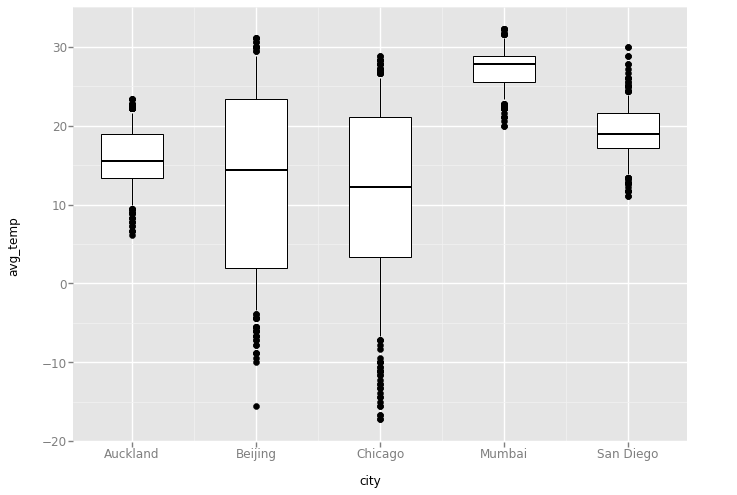

<ggplot: (8739413238006)>

In [149]:
from ggplot import *

ggplot(aes(y='avg_temp', x = 'city'), data = dane) + geom_boxplot() # geom_violin()
#ggplot(aes(y='avg_wind', x = 'city'), data = dane) + geom_boxplot()
#ggplot(aes(y='precip', x = 'city'), data = dane) + geom_boxplot()
#ggplot(aes(y='avg_temp', x = 'month'), data = dane) + geom_boxplot()
#ggplot(aes(y='avg_temp', x = 'events'), data = dane) + geom_boxplot()
#vis, dewpt,huminidy


In [161]:
#wykres temperatury w zależności od czegoś

In [162]:
#dane_sorted_by_avg_temp = dane.sort_values(by=['avg_temp'])
#dane_sorted_by_avg_temp['avg_temp'].plot(use_index=False)

In [178]:
#histogramy

Korelacja liniowa cech

In [176]:
dane.iloc[:,5:25].corr()

,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,low_dewpt,high_humidity,avg_humidity,low_humidity,high_hg,avg_hg,low_hg,high_vis,avg_vis,low_vis,high_wind,avg_wind,max_wind_gust,precip
high_temp,1.000000,0.973468,0.896853,0.863094,0.819264,0.756047,0.045322,-0.019281,-0.081429,-0.640623,-0.561921,-0.473889,-0.347900,-0.350375,-0.201081,-0.159177,-0.293804,-0.157169,0.062956
avg_temp,0.973468,1.000000,0.973786,0.929823,0.904736,0.858209,0.119321,0.135329,0.099550,-0.690743,-0.605010,-0.508510,-0.396188,-0.359470,-0.189131,-0.133247,-0.223113,-0.143843,0.099023
low_temp,0.896853,0.973786,1.000000,0.948967,0.943852,0.916365,0.190195,0.283944,0.274361,-0.705148,-0.617164,-0.517119,-0.428421,-0.357664,-0.174577,-0.102962,-0.142194,-0.129344,0.130493
high_dewpt,0.863094,0.929823,0.948967,1.000000,0.982215,0.941952,0.399432,0.437810,0.366775,-0.714928,-0.646915,-0.561598,-0.525034,-0.487767,-0.309019,-0.098009,-0.151902,-0.165095,0.159510
avg_dewpt,0.819264,0.904736,0.943852,0.982215,1.000000,0.982837,0.440025,0.525677,0.462329,-0.708098,-0.632422,-0.540523,-0.552806,-0.487385,-0.289046,-0.113026,-0.142424,-0.178962,0.163504
low_dewpt,0.756047,0.858209,0.916365,0.941952,0.982837,1.000000,0.450089,0.581813,0.542278,-0.677423,-0.595002,-0.501062,-0.558787,-0.460349,-0.250140,-0.123472,-0.119998,-0.187347,0.165285
high_humidity,0.045322,0.119321,0.190195,0.399432,0.440025,0.450089,1.000000,0.821277,0.606416,-0.240723,-0.248756,-0.238735,-0.307551,-0.397996,-0.399629,-0.022699,-0.002114,-0.162970,0.152964
avg_humidity,-0.019281,0.135329,0.283944,0.437810,0.525677,0.581813,0.821277,1.000000,0.923449,-0.295440,-0.286320,-0.261440,-0.440932,-0.353015,-0.250214,0.013355,0.125539,-0.112508,0.203120
low_humidity,-0.081429,0.099550,0.274361,0.366775,0.462329,0.542278,0.606416,0.923449,1.000000,-0.278837,-0.268452,-0.246107,-0.393906,-0.201635,-0.084594,0.091746,0.253916,-0.021387,0.214349
high_hg,-0.640623,-0.690743,-0.705148,-0.714928,-0.708098,-0.677423,-0.240723,-0.295440,-0.278837,1.000000,0.973701,0.914854,0.349045,0.355873,0.263105,-0.066665,-0.062657,-0.042999,-0.175899


Raport

In [177]:
pandas_profiling.ProfileReport(dane)

Number of variables,30
Number of observations,3655
Total Missing (%),0.0%
Total size in memory,856.7 KiB
Average record size in memory,240.0 B
Numeric,13
Categorical,3
Boolean,6
Date,0
Text (Unique),0
Rejected,8
